In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41

  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def load_data(self, n_items=None):
    data = pd.read_csv(self.FILENAME)
    if n_items != None:
      data = data.iloc[0:n_items,:]
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

In [3]:
isear_dataset = ISEARDataset()
isear_data = isear_dataset.load_data()
# isear_data = isear_dataset.load_data(200)
train_data, test_data = train_test_split(isear_data, test_size=0.3, random_state=isear_dataset.RANDOM_STATE, stratify=isear_data["emotion"].values)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=isear_dataset.RANDOM_STATE, stratify=train_data.emotion)

print("train_data.shape: (%d, %d)" % train_data.shape)
print("valid_data.shape: (%d, %d)" % valid_data.shape)
print("test_data.shape: (%d, %d)" % test_data.shape)

train_data.shape: (4292, 2)
valid_data.shape: (1074, 2)
test_data.shape: (2300, 2)


class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
number of bins: 7


/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


bins: [0, 1, 2, 3, 4, 5, 6, 7]


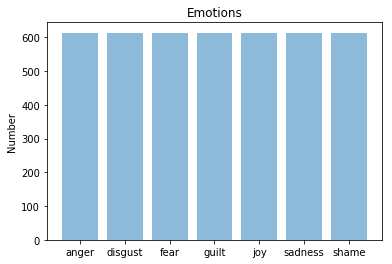

In [4]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]

bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [ ]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(isear_data['emotion'].apply(lambda x:dic[x])).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([7666, 1, 1, 1])
y_onehot.shape: torch.Size([7666, 7, 1, 1])


In [ ]:
import torch
from torch.utils import data
from allennlp.modules.elmo import batch_to_ids


class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, input_data, num_class=2):
    X = torch.tensor(batch_to_ids(input_data['text'].values))
    y = torch.LongTensor(input_data['emotion'].apply(lambda x:dic[x])).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [ ]:
isear_tensor_dataset = ISEAR_Tensor_Dataset(isear_data, num_class=7)

In [ ]:
print("isear_tensor_dataset.tensors[0].shape:", isear_tensor_dataset.tensors[0].shape)
print("isear_tensor_dataset.tensors[1].shape:", isear_tensor_dataset.tensors[1].shape)

In [ ]:
train_length = int(0.7*len(isear_tensor_dataset))
test_length = len(isear_tensor_dataset) - train_length
train_dataset, test_dataset = data.random_split(isear_tensor_dataset, (train_length, test_length))

train_length = int(0.8*len(train_dataset))
valid_length = len(train_dataset) - train_length
train_dataset, valid_dataset = data.random_split(train_dataset, (train_length, valid_length))

print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

In [ ]:
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Load Elmo

In [ ]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0)
elmo = elmo.to(device)

### Test Elmo Embedder

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder


options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

elmo_embedder = ElmoEmbedder(options_file, weight_file)
tokens = ["I", "ate", "an", "apple", "for", "breakfast"]
vectors = elmo_embedder.embed_sentence(tokens)

import scipy
vectors2 = elmo_embedder.embed_sentence(["I", "ate", "a", "carrot", "for", "breakfast"])
scipy.spatial.distance.cosine(vectors[2][3], vectors2[2][3]) # cosine distance between "apple" and "carrot" in the last layer


In [ ]:
print("vectors.shape:", vectors.shape)
print("vectors2.shape:", vectors2.shape)

print("vectors[2][3].shape:", vectors[2][3].shape)
print("vectors2[2][3].shape:", vectors2[2][3].shape)

### Test Elmo Module

In [ ]:
shape = train_dataset[0][0].shape
X_train = train_dataset[0][0].view(1, shape[0], shape[1]).to(device)
print("X_train.shape:", X_train.shape)

embedded = elmo(X_train)
print("embedded shape:", embedded['elmo_representations'][0].shape)

In [ ]:
import scipy

sentences = [
  ["I", "ate", "an", "apple", "for", "breakfast"], 
  ["I", "ate", "a", "carrot", "for", "breakfast"]
]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids.to(device))
embeddings['elmo_representations'][0][0]

In [ ]:
vector1 = embeddings['elmo_representations'][0][0].cpu().detach().numpy()
vector2 = embeddings['elmo_representations'][0][1].cpu().detach().numpy()
scipy.spatial.distance.cosine(vector1[3], vector2[3]) # cosine distance between "apple" and "carrot" in the last layer

## Neural Network Architecture 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
  
    def _transpose_embedding(self, x):
        return x.permute(1, 0, 2)

    def __init__(self, elmo_embedding, input_dim, embedding_dim, 
                 hidden_dim, batch_size, output_dim=1, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.elmo = elmo_embedding
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.num_layers)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, sentence):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        embeds = self.elmo(sentence)['elmo_representations'][0]
        # print("embeds.shape:", embeds.shape)
        transposed_embeds = self._transpose_embedding(embeds)
        # print("transposed_embeds.shape:", transposed_embeds.shape)
        lstm_out, self.hidden = self.lstm(transposed_embeds)
        # print("lstm_out.shape:", lstm_out.shape)
        flatten = self.linear(lstm_out[-1].view(-1, self.hidden_dim))
        # print("flatten.shape:", flatten.shape)
        output = self.sigmoid(flatten)
        # print("output.shape:", output.shape)
        return output

In [ ]:
input_dim = X_train.shape[1]
embedding_dim = 256
hidden_dim = 256
batch_size = 10
output_dim = n_classes
model = LSTMClassifier(elmo, input_dim, embedding_dim, hidden_dim, batch_size, output_dim)
model = model.to(device)

In [ ]:
train_loader.__dict__

In [ ]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 100
learning_rate = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()
    model.hidden = model.init_hidden()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()

        output = model(data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    hist[epoch] = loss.item()
    
    #####################
    # Evaluation model
    #####################
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1][0] # get the index of the max log-probability
            target = target.max(1, keepdim=True)[1][0]
            correct += pred.eq(target.view_as(pred)).item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))